In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import normalize
from IPython.display import display



import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
pd.set_option('display.max_rows', 20)

cuda


In [2]:
headers = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'percentile', 'collegeLevel', 'collegeScore', 'accepted']
# header_type = [int, bool, bool,    bool,    bool,    bool,       bool,       float,  int,    float,       int,       float,      bool,   float,    int,               float,         int,              float,        bool]

n_extra_var = 7
n_latent_var = 8
for i in range(n_extra_var):
    headers.insert(-3,'var_'+str(i))

In [3]:
df = pd.read_csv("college_acceptance_10001_gaussian.csv", index_col=0)
df.drop(df.index[-1],inplace=True)

In [4]:
print(df.columns)

Index(['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'gpa',
       'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays',
       'extracurriculars', 'percentile', 'var_0', 'var_1', 'var_2', 'var_3',
       'var_4', 'var_5', 'var_6', 'collegeLevel', 'collegeScore', 'accepted'],
      dtype='object')


In [5]:
# Exogenous: 'age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'percentile'
# Endogenous: (Dependencies)
#   Percentile: 'SAT', 'SATWriting', 'APTests', 'APScores', 'STEM', 'essays', 'extracurriculars', 'collegeLevel'
#   Application Data: 'collegeScore'
#   collegeScore: 'accepted'

In [6]:
X_headers = ['age', 'sex', 'white', 'asian', 'black', 'hispanic', 'otherRace', 'STEM', 'percentile', 'collegeLevel']
C_headers = ['gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'essays', 'extracurriculars', 'collegeLevel']
C_headers_missing = ['gpa', 'SAT', 'SATWriting', 'APTests', 'APScores', 'extracurriculars']
Y_headers = ['accepted']
CY_headers = C_headers + Y_headers

X = df.loc[:,X_headers].values
Cy = df.loc[:,CY_headers].values
Cy_norm = Cy / np.max(Cy, axis=0)
X_train, X_test, Cy_train, Cy_test = train_test_split(X, Cy_norm, train_size=.7)


In [7]:
train_X = torch.Tensor(X_train)
train_Cy = torch.Tensor(Cy_train)
test_X = torch.Tensor(X_test)
test_Cy = torch.Tensor(Cy_test)
training_dataset = TensorDataset(train_X, train_Cy)
train_loader = DataLoader(training_dataset, batch_size=1024, shuffle=True)
testing_dataset = TensorDataset(test_X, test_Cy)
test_loader = DataLoader(testing_dataset, batch_size=1024, shuffle=True)

In [14]:
x_to_c_model = nn.Sequential(nn.Linear(len(X_headers), 32),
                      nn.ReLU(),
                      nn.Linear(32,32),
                      nn.ReLU(),
                      nn.Linear(32,32),
                      nn.ReLU(),
                      nn.Linear(32, len(C_headers)),
                      nn.ReLU()).to(device)
print(x_to_c_model)

c_to_y_model = nn.Sequential(nn.Linear(len(C_headers), 16),
                      nn.ReLU(),
                      nn.Linear(16,16),
                      nn.ReLU(),
                      nn.Linear(16, len(Y_headers)),
                      nn.Sigmoid()).to(device)
print(c_to_y_model)

class FullModel(torch.nn.Module):
    def __init__(self, x_to_c_model, c_to_y_model):
        super(FullModel, self).__init__()
        self.x_to_c_model = x_to_c_model
        self.c_to_y_model = c_to_y_model
    
    def forward(self, x):
        c_out = self.x_to_c_model(x)
        y_out = self.c_to_y_model(c_out)
        return c_out, y_out
    
model = FullModel(x_to_c_model, c_to_y_model)

print(model)

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=8, bias=True)
  (7): ReLU()
)
Sequential(
  (0): Linear(in_features=8, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): ReLU()
  (4): Linear(in_features=16, out_features=1, bias=True)
  (5): Sigmoid()
)
FullModel(
  (x_to_c_model): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=8, bias=True)
    (7): ReLU()
  )
  (c_to_y_model): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear

In [ ]:
# C_TO_Y Model Tests
loss_function = nn.BCELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(c_to_y_model.parameters(), lr=learning_rate)

In [180]:
# C_to_Y Model TESTS

def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    batches = 0
    for batch, data in enumerate(train_loader):
        batches += 1
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        y_out = c_to_y_model(labels[:,:-1])
        loss = loss_function(y_out.squeeze(), labels[:,-1])
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()

    return running_loss / batches

EPOCHS = 50
losses_epoch = []

for epoch in range(EPOCHS):
    c_to_y_model.train(True)
    avg_loss = train_one_epoch(epoch)
    losses_epoch.append(avg_loss)
    print('EPOCH {}: Loss: {:.5f}'.format(epoch, losses_epoch[-1]))
    c_to_y_model.train(False)

EPOCH 0: Loss: 0.24941
EPOCH 1: Loss: 0.25207
EPOCH 2: Loss: 0.25171
EPOCH 3: Loss: 0.24843
EPOCH 4: Loss: 0.25116
EPOCH 5: Loss: 0.25029
EPOCH 6: Loss: 0.25145
EPOCH 7: Loss: 0.25074
EPOCH 8: Loss: 0.24944
EPOCH 9: Loss: 0.25095
EPOCH 10: Loss: 0.25011
EPOCH 11: Loss: 0.24907
EPOCH 12: Loss: 0.24789
EPOCH 13: Loss: 0.25106
EPOCH 14: Loss: 0.25006
EPOCH 15: Loss: 0.25161
EPOCH 16: Loss: 0.25167
EPOCH 17: Loss: 0.25072
EPOCH 18: Loss: 0.25032
EPOCH 19: Loss: 0.24991
EPOCH 20: Loss: 0.25051
EPOCH 21: Loss: 0.25152
EPOCH 22: Loss: 0.25024
EPOCH 23: Loss: 0.24973
EPOCH 24: Loss: 0.25103
EPOCH 25: Loss: 0.25370
EPOCH 26: Loss: 0.24987
EPOCH 27: Loss: 0.25185
EPOCH 28: Loss: 0.25130
EPOCH 29: Loss: 0.25126
EPOCH 30: Loss: 0.25006
EPOCH 31: Loss: 0.24887
EPOCH 32: Loss: 0.24963
EPOCH 33: Loss: 0.24957
EPOCH 34: Loss: 0.24914
EPOCH 35: Loss: 0.25031
EPOCH 36: Loss: 0.24962
EPOCH 37: Loss: 0.25004
EPOCH 38: Loss: 0.25063
EPOCH 39: Loss: 0.24992
EPOCH 40: Loss: 0.25066
EPOCH 41: Loss: 0.25022
EP

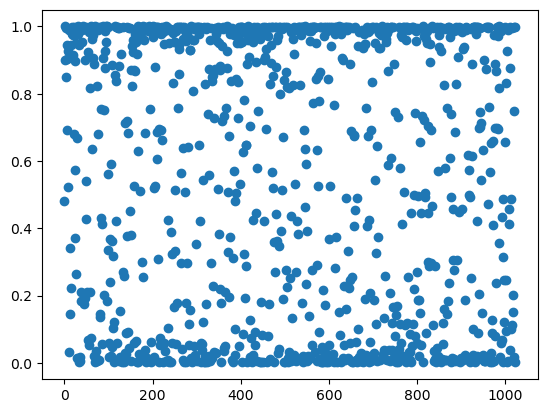

In [181]:
# testing
running_loss = 0.
last_loss = 0.
for batch, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    y_out = c_to_y_model(labels[:,:-1])
    plt.scatter(range(y_out.shape[0]), y_out.cpu().detach().numpy())
    plt.show()
    break

    # Gather data and report
    running_loss += loss.item()
    if batch % 1 == 0:
        last_loss = running_loss / 100 # loss per batch
        print('  batch {} loss: {}'.format(batch + 1, last_loss))
        running_loss = 0.

In [15]:
# Full Model Tests
loss_function = nn.BCELoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
label_loss_weight = 1
attr_loss_weight = 0.2
attr_criterion = []
for _ in range(len(C_headers)):
    attr_criterion.append(nn.MSELoss())

In [16]:
def train_one_epoch(epoch_index):
    running_loss = 0.
    last_loss = 0.
    for batch, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        c_out, y_out = model(inputs)
        losses = []
        losses.append(label_loss_weight * loss_function(y_out, labels[:,-1:]))
        # print(c_out[0].shape, labels)
        for j in range(len(attr_criterion)):
            losses.append(attr_loss_weight*attr_criterion[j](c_out[:,j], labels[:,j])) # potentially incorrect
        # print(losses[0].item(), (sum(losses[1:])/len(attr_criterion)).item())
        loss = sum(losses)
        loss.backward()
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if batch % 20 == 0:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(batch + 1, last_loss))
            tb_x = epoch_index * len(train_loader) + i + 1
            running_loss = 0.

    return last_loss

EPOCHS = 50
losses_epoch = []

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch))
    model.train(True)
    avg_loss = train_one_epoch(epoch)
    losses_epoch.append(avg_loss)
    model.train(False)

EPOCH 0:
  batch 1 loss: 0.011268261671066284
EPOCH 1:
  batch 1 loss: 0.009901015758514405
EPOCH 2:
  batch 1 loss: 0.009684281349182129
EPOCH 3:
  batch 1 loss: 0.009593030214309692
EPOCH 4:
  batch 1 loss: 0.009379690885543824
EPOCH 5:
  batch 1 loss: 0.008791353702545166
EPOCH 6:
  batch 1 loss: 0.00869291365146637
EPOCH 7:
  batch 1 loss: 0.008589076399803162
EPOCH 8:
  batch 1 loss: 0.008577961921691895
EPOCH 9:
  batch 1 loss: 0.008464843630790711
EPOCH 10:
  batch 1 loss: 0.008370449542999267
EPOCH 11:
  batch 1 loss: 0.008192510008811951
EPOCH 12:
  batch 1 loss: 0.007937973737716675
EPOCH 13:
  batch 1 loss: 0.007781171202659607
EPOCH 14:
  batch 1 loss: 0.007468003630638122
EPOCH 15:
  batch 1 loss: 0.00746070384979248
EPOCH 16:
  batch 1 loss: 0.007038207650184631
EPOCH 17:
  batch 1 loss: 0.006688548922538757
EPOCH 18:
  batch 1 loss: 0.006233207583427429
EPOCH 19:
  batch 1 loss: 0.005643911957740784
EPOCH 20:
  batch 1 loss: 0.005367382168769836
EPOCH 21:
  batch 1 loss:

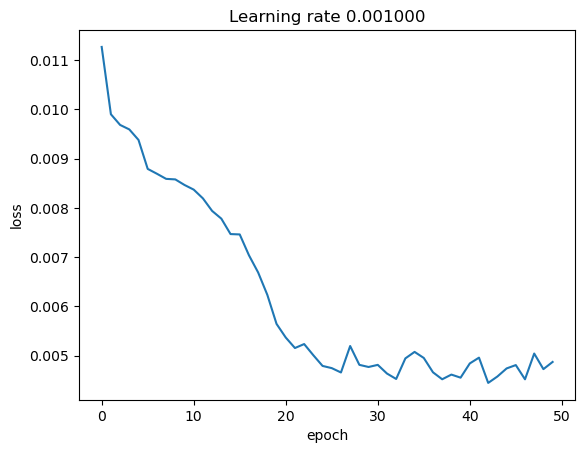

In [17]:
plt.plot(losses_epoch)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

,age,sex,white,asian,black,hispanic,otherRace,STEM,percentile,collegeLevel,gpa,SAT,SATWriting,APTests,APScores,essays,extracurriculars,collegeLevel,accepted
0,16.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.730627,0.0,3.463726,1237.154675,6.474833,0.000000,2.685155,0.558234,1.091559,0.000000,1.000000
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1332.144547,5.585888,0.141520,3.215491,0.617240,0.850113,0.000000,0.985123
2,17.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.630362,1.0,3.303705,1356.072903,3.962885,1.000000,2.411174,0.378565,2.947548,1.000000,0.000000
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1213.842678,5.118608,2.172326,3.059340,0.543310,2.650114,1.131220,0.489670
4,17.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.966628,2.0,3.497366,1600.000000,7.093156,9.000000,4.039258,0.935581,11.979360,2.000000,1.000000
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1584.511566,7.226793,1.620532,4.297981,0.924994,2.201279,1.298697,0.714486
6,18.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.903110,3.0,3.761510,1191.346359,6.015184,1.000000,4.405227,0.976926,2.900176,3.000000,0.000000
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1556.320953,6.827570,5.432188,4.311217,0.902216,5.870971,2.843067,0.005921
8,18.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.855714,0.0,3.167340,1550.649166,7.013753,4.000000,3.094490,0.672763,4.444363,0.000000,1.000000
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,1613.524628,6.941812,0.000000,3.920202,0.779397,0.000000,0.000000,0.994165


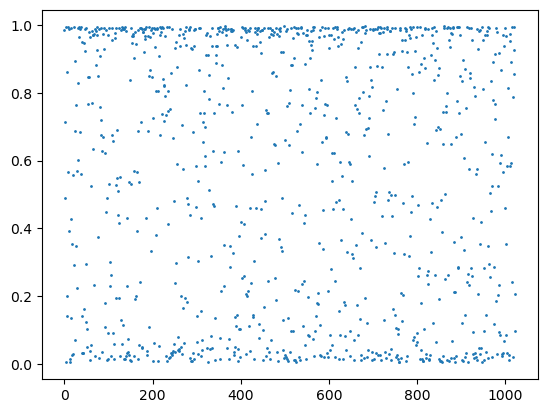

In [13]:
# testing
running_loss = 0.
last_loss = 0.
for batch, data in enumerate(test_loader):
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    c_out, y_out = model(inputs)
    losses = []
    losses.append(loss_function(y_out.squeeze(), labels[:,-1]))
    for j in range(len(attr_criterion)):
        losses.append(attr_criterion[j](c_out[j], labels[j,:-1]))
    loss = sum(losses) / len(attr_criterion)

    # Display
    outputs = c_out.cpu().detach().numpy()* np.max(Cy[:,:-1], axis=0)
    inputs_empty = np.empty(inputs.shape)
    inputs_empty.fill(np.nan)
    labels_out = y_out.cpu().detach().numpy()
    outputs_full = np.concatenate((outputs , labels_out), axis=1)
    predictions = np.concatenate((inputs_empty, outputs_full), axis=1)
    inputs_test = np.concatenate((inputs.cpu().detach().numpy(), labels.cpu().detach().numpy() * np.max(Cy, axis=0)), axis=1)
    result = np.hstack([inputs_test,predictions]).reshape(predictions.shape[0]*2, predictions.shape[1])
    test_headers = list(X_headers)
    test_headers.extend(C_headers)
    test_headers.extend(Y_headers)
    df_test = pd.DataFrame(result, columns=test_headers)
    with pd.option_context('display.max_rows', 20):
        display(df_test.head(20))
    plt.scatter(range(y_out.shape[0]), labels_out,s=1)
    plt.show()
    break

    # Gather data and report
    running_loss += loss.item()
    if batch % 1 == 0:
        last_loss = running_loss / 100 # loss per batch
        print('  batch {} loss: {}'.format(batch + 1, last_loss))
        running_loss = 0.

In [169]:
# clf = tree.DecisionTreeClassifier()
clf = LogisticRegression(random_state=0)
# clf = SVC(kernel="linear", C=0.025, random_state=42)
# clf = SVC(gamma=2, C=1, random_state=42)
# clf = RandomForestClassifier(random_state=42)
# print(Cy_train[:,-1].reshape(Cy_train.shape[0],1).shape)
clf = clf.fit(Cy_train[:,:-1], Cy_train[:,-1].reshape(Cy_train.shape[0],1))

/home/coco/anaconda3/lib/python3.11/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [170]:
y_pred = clf.predict(Cy_test[:,:-1])
print("Accuracy:",metrics.accuracy_score(Cy_test[:,-1], y_pred))
print("BCE Loss:",metrics.log_loss(Cy_test[:,-1], y_pred))
print("L1 loss:", metrics.mean_absolute_error(Cy_test[:,-1], y_pred))

Accuracy: 0.8831168831168831
BCE Loss: 4.212894551974732
L1 loss: 0.11688311688311688


<Figure size 1400x1400 with 0 Axes>

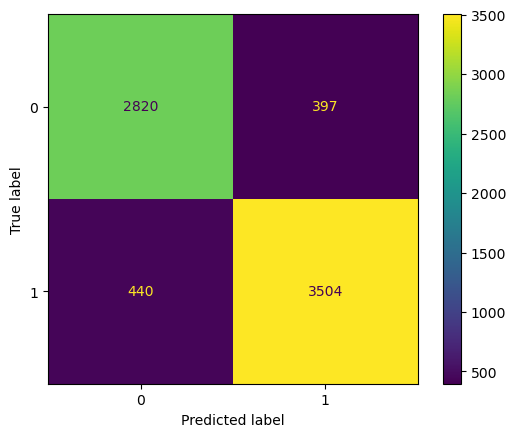

In [171]:
cm = confusion_matrix(Cy_test[:,-1], y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(14,14))
disp.plot()
plt.show()

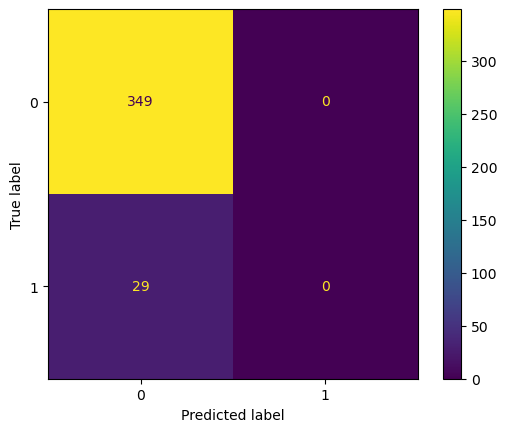

In [172]:
college_levels = np.unique(Cy_test[:, C_headers.index("collegeLevel")])
index = np.in1d(Cy_test[:, C_headers.index("collegeLevel")], [college_levels[3]])
y_test2 = Cy_test[index,-1]
y_pred2 = y_pred[index]
# print(y_test2.shape, y_pred2.shape)
cm = confusion_matrix(y_test2, y_pred2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

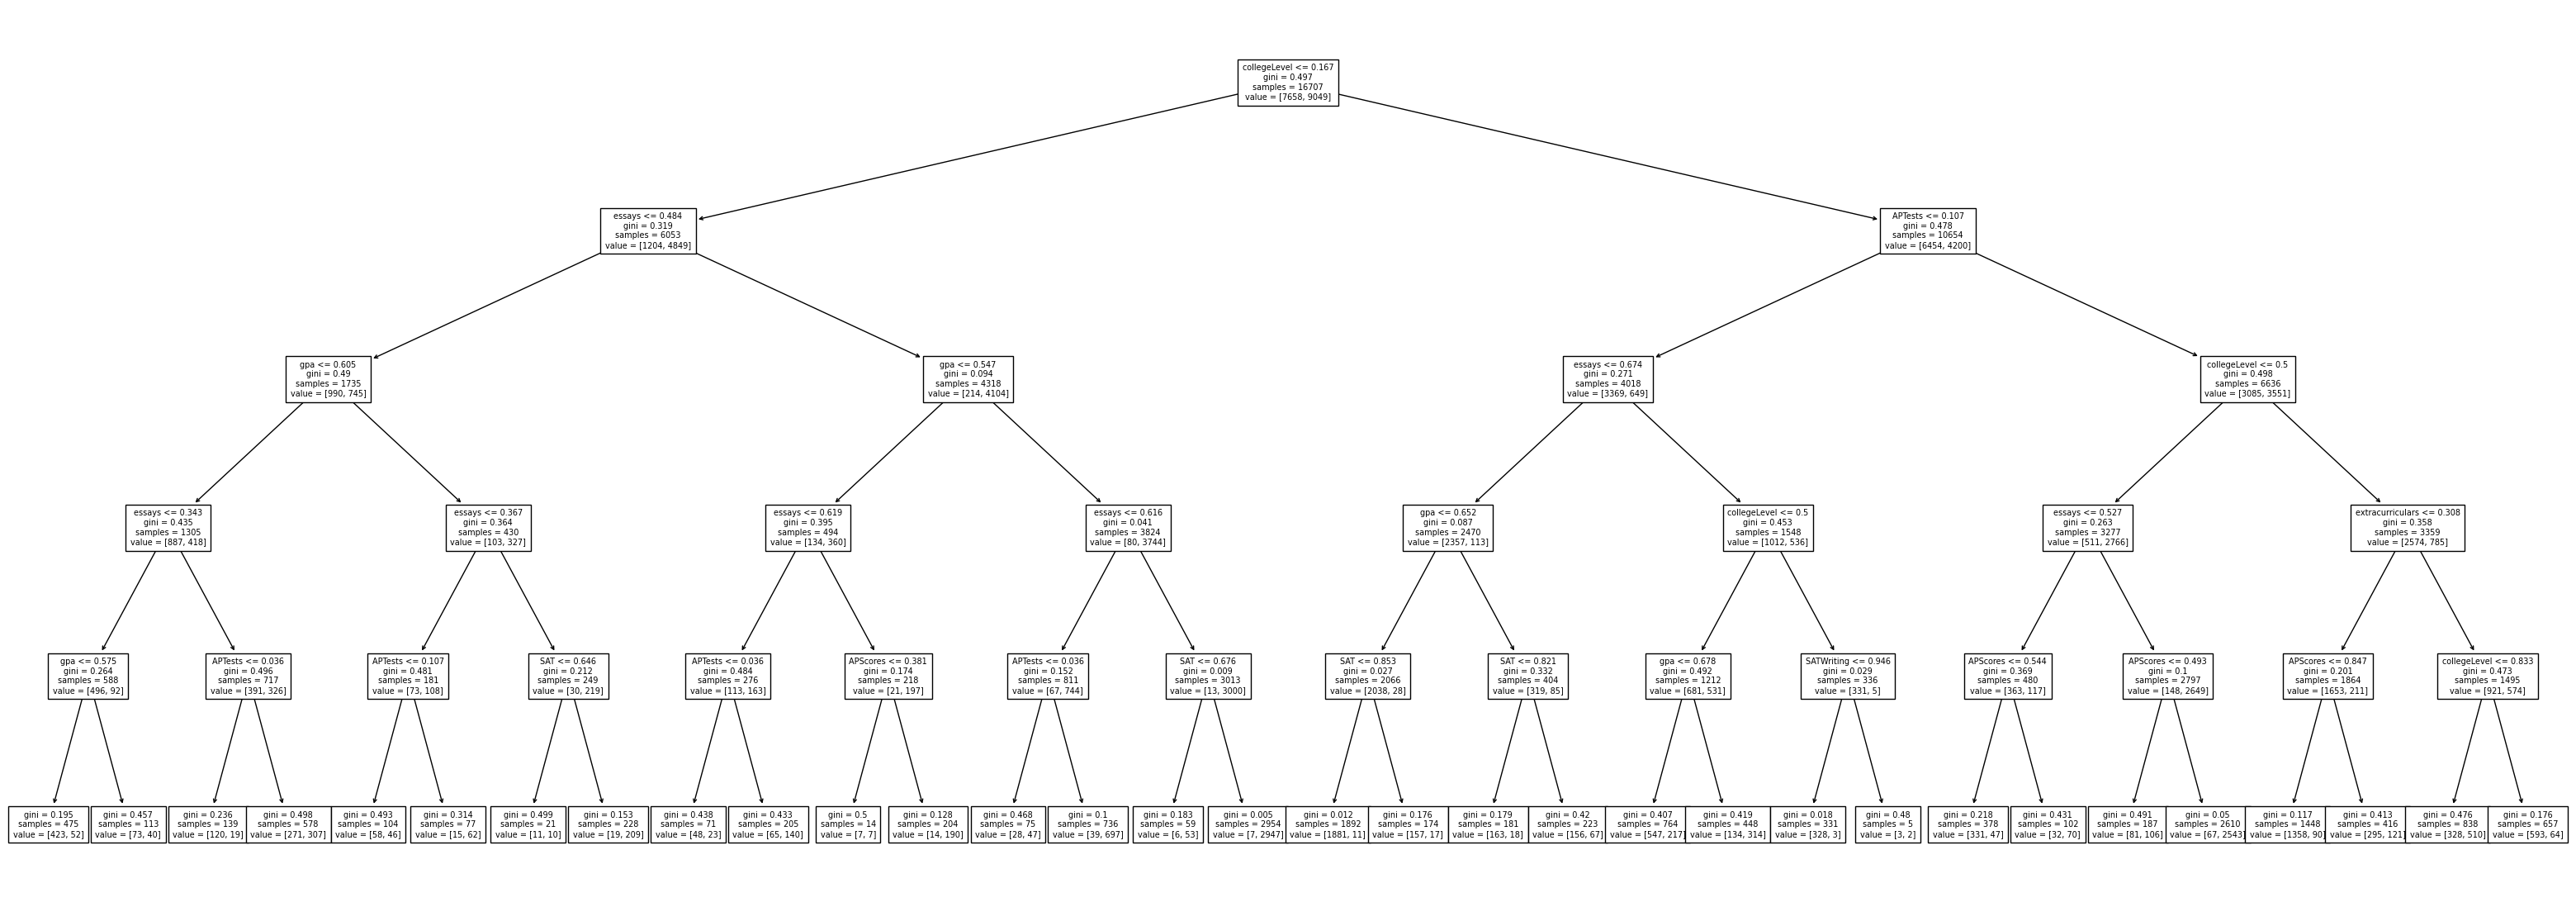

In [145]:
plt.figure(figsize=(40,14))
tree.plot_tree(clf, max_depth=5,fontsize=7, feature_names=C_headers)
plt.savefig('tree_high_dpi', dpi=100)